In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

IN_COLAB = "google.colab" in sys.modules
IN_COLAB

True

# Setup environment

In [3]:
if IN_COLAB:
    from google.colab import drive

    drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
if IN_COLAB:
    # Put here the full path to the folder having the project code and Dataset
    # e.g. "/content/drive/MyDrive/assignment"
    ROOT_DIR = "/content/drive/MyDrive/My_projects/Unsup_seg_GBM"
    %cd $ROOT_DIR

/content/drive/MyDrive/My_projects/Unsup_seg_GBM


In [5]:
if IN_COLAB:
    # This will make sure we have installed all the proper dependencies
    # Instal dependencies
    !pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 49.9 MB/s eta 0:00:00
  Attempting uninstall: nibabel
    Found existing installation: nibabel 3.0.2
    Uninstalling nibabel-3.0.2:
      Successfully uninstalled nibabel-3.0.2


# Setup import

In [14]:
import os

from src import config
from src.get_data import get_file_data_label

import torch


import time
import matplotlib.pyplot as plt
from monai.config import print_config
from monai.data import DataLoader, decollate_batch
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.metrics import DiceMetric
from monai.networks.nets import SegResNet
from monai.handlers.utils import from_engine
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    EnsureChannelFirstd,
    EnsureTyped,
    Orientationd,
    Spacingd,
    NormalizeIntensityd,
    RandSpatialCropd,
    RandFlipd,
    RandScaleIntensityd,
    RandShiftIntensityd,
    Activations,
    AsDiscrete,
    Invertd,
    Activationsd,
    AsDiscreted,
    )
from monai.data import (Dataset, DataLoader)
from monai.utils import first
from monai.networks.nets import SegResNet
from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.utils import set_determinism

import matplotlib.pyplot as plt

print_config()

MONAI version: 1.2.0
Numpy version: 1.25.0
Pytorch version: 2.0.1+cpu
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\monai\__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 10.0.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.0.3
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
py

### Set deterministic training for reproducibility

In [3]:
set_determinism(seed=0)

### Get fullpath for every MRI study case.
Each case has a folder with 11 MRI modalities (T1, T2, DSC-rCBV, DTI-AD...)  and volume label. All MRI volume in format .nn.gz

In [27]:
# Get train and validation dataset.
# train_files and val_files are a List[Dict] ->[{'image':[paths of MRI volumes], 'label':[path of label volume]}
modalities=['FLAIR.','T1.','T1GD.','T2.',]

train_files= get_file_data_label(config.DATA_TRAIN, config.LABEL_TRAIN, modalities)
val_files=get_file_data_label(config.DATA_TEST, config.LABEL_TEST, modalities)

print('Number of Train cases:',len(train_files))
print('Number of Modalities by cases:',len(train_files[0]['image']))
print('Number of Validation cases:',len(val_files))
print('Number of Modalities by cases:',len(val_files[0]['image']))

Number of Train cases: 10
Number of Modalities by cases: 4
Number of Validation cases: 1
Number of Modalities by cases: 4


### Define a new transform to convert brain tumor labels
Here we convert the multi-classes labels into multi-labels segmentation task in One-Hot format.

In [29]:
class ConvertToMultiChannelBasedOnBratsClassesd(MapTransform):
    """
    Convert labels to multi channels based on brats classes:
    label 1 is necrosis
    label 2 is edema
    label 3 is activo
    The possible classes are N (necrosis), E (edema)
    and TA (active).

    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            result = []
            # label 1 necro
            result.append(d[key] == 1)
            # label 2 is ET
            result.append(d[key] == 2)
            # merge labels 3, 4 and 3 to construct activo
            result.append(torch.logical_or(d[key] == 3, d[key] == 4))

            d[key] = torch.stack(result, axis=0).float()
        return d

### Setup transforms for training and validation

In [30]:
# Do transformations to create tensors
# Transformations for Data train
train_transform = Compose([
        LoadImaged(keys=["image", "label"], image_only=False),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        RandSpatialCropd(keys=["image", "label"], roi_size=[224, 224, 144], random_size=False), # Random transformation for
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),                           # data augmentation
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
        RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),                     # Zscore normalization for intensity
        RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
        RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),

])

# Transformations for Data validation
val_transform = Compose(
    [
        LoadImaged(keys=["image", "label"], image_only=False),
        EnsureChannelFirstd(keys="image"),
        EnsureTyped(keys=["image", "label"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(
            keys=["image", "label"],
            pixdim=(1.0, 1.0, 1.0),
            mode=("bilinear", "nearest"),
        ),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

## Create iterable Dataset and its Dataloader using train and validation files paths.

In [31]:
# Create iterable Dataset and its Dataloader for Data train
train_ds = Dataset(data=train_files,transform=train_transform, )
train_loader = DataLoader(train_ds, batch_size=1, ) #num_workers=8

# Create iterable Dataset and its Dataloader for Data validation
val_ds = Dataset(data=val_files,transform=val_transform, )
val_loader = DataLoader(val_ds, batch_size=1,) #num_workers=8

## Check output tensors of the DataLoader

In [32]:
# Get one batch for the Dataloader and chek tensor dimensions of Data and labels
# The dimensions are [batch, channels, x,y,z].
# channels=11 for Data (11 modalities) and 3 for label(3 clases)

patient=first(train_loader)
print('batch of Train MRI: ',patient['image'].shape)
print('batch of Train Labels: ', patient['label'].shape)


batch of Train MRI:  torch.Size([1, 4, 224, 224, 144])
batch of Train Labels:  torch.Size([1, 3, 224, 224, 144])


In [39]:
val_data_example = val_ds[0]
val_data_example['image'].shape[0]

4

## Check data shape and visualize

image shape: torch.Size([4, 240, 240, 155])


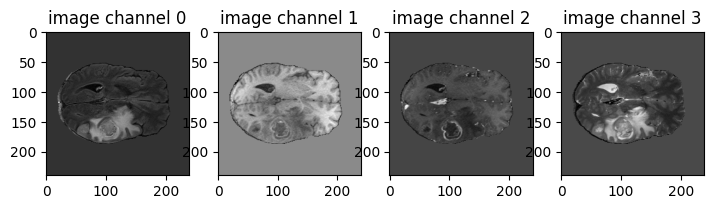

label shape: torch.Size([3, 240, 240, 155])


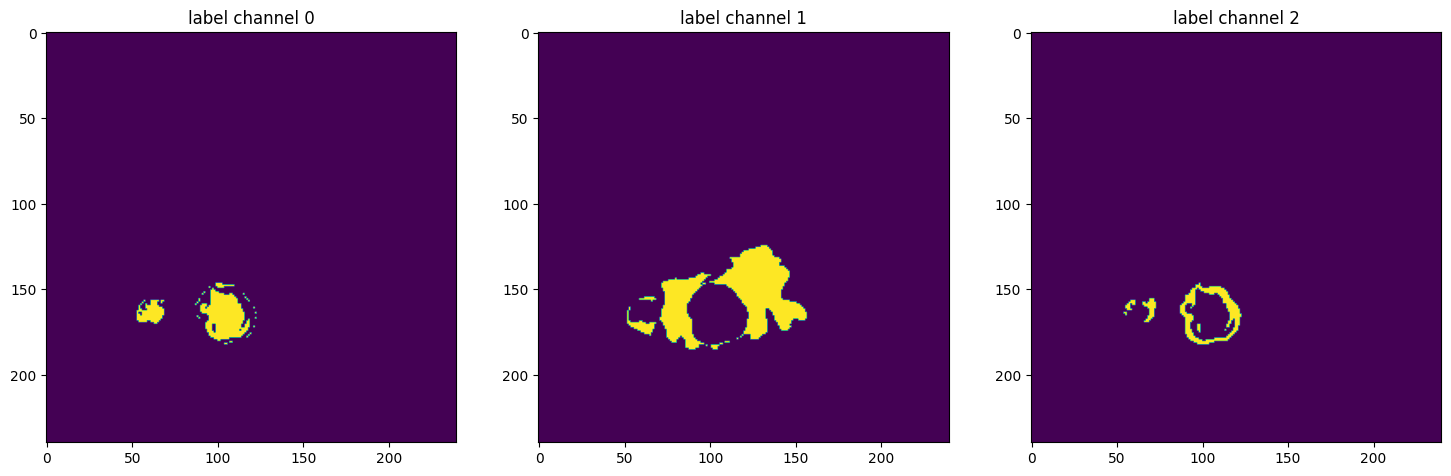

In [40]:

# pick one case from validation dataset to visualize and check the 11 channels
sl = 60
idx=0
val_data_example = val_ds[idx]
print(f"image shape: {val_data_example['image'].shape}")
plt.figure("image", (24, 6))
for i in range(val_data_example['image'].shape[0]):
    plt.subplot(1, 11, i + 1)
    plt.title(f"image channel {i}")
    plt.imshow(val_data_example["image"][i, :, :, sl].detach().cpu(), cmap="gray")
plt.show()

# also visualize the 3 channels label corresponding to this case
print(f"label shape: {val_data_example['label'].shape}")
plt.figure("label", (18, 6))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plt.title(f"label channel {i}")
    plt.imshow(val_data_example["label"][i, :, :, sl].detach().cpu())
plt.show()

# Create Model, Loss, Optimizer

In [41]:
# Select device gpu or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
!nvidia-smi

Device: cpu


"nvidia-smi" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [47]:
# Train and validation configuration
max_epochs = 3
val_interval = 1
VAL_AMP = True
in_channels=train_ds[0]['image'].shape[0]

# standard PyTorch program style: create SegResNet, DiceLoss and Adam optimizer
# Create SegResNet architechure
model = SegResNet(
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    in_channels=in_channels,
    out_channels=3,
    dropout_prob=0.2,
).to(device)

# Loos function to use
loss_function = DiceLoss(smooth_nr=0, smooth_dr=1e-5, squared_pred=True, to_onehot_y=False, sigmoid=True)

# Optimizer, ADAM optimizer with learning rate 1e-4
optimizer = torch.optim.Adam(model.parameters(), 1e-4, weight_decay=1e-5)

# The code also creates a learning rate scheduler.
# The learning rate scheduler adjusts the learning rate during training to improve model convergence.
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Use Monai class DiceMetric to calculate Dices.
# The fund is included as an additional class in the calculation of the Dice coefficient.
# The average Dice coefficient will be calculated for all classes.
dice_metric = DiceMetric(include_background=True, reduction="mean")
#Calculate the Dice coefficient at the batch level.
dice_metric_batch = DiceMetric(include_background=True, reduction="mean_batch")

# Sequence of transformations to be applied to model predictions after inference.
post_trans = Compose([Activations(sigmoid=True), AsDiscrete(threshold=0.5)])

# define inference method
# Define an inference method using the sliding window method.
def inference(input):
    def _compute(input):
        return sliding_window_inference(
            inputs=input,
            roi_size=(240, 240, 160),
            sw_batch_size=1,
            predictor=model,
            overlap=0.5,
        )

    if VAL_AMP: # Perform inference with mixed precission
        with torch.cuda.amp.autocast():
            return _compute(input)
    else:      # Perform inference without mixed precission
            return _compute(input)

# use amp to accelerate training
# accelerate training using the mixed precision technique.
scaler = torch.cuda.amp.GradScaler()
# enable cuDNN benchmark
# Enable cuDNN benchmarking, to optimize the performance of GPU convolution operations.
torch.backends.cudnn.benchmark = True

torch.cuda.empty_cache()


In [48]:
best_metric = -1
best_metric_epoch = -1
best_metrics_epochs_and_time = [[], [], []]
epoch_loss_values = []
metric_values = []
metric_values_tc = []
metric_values_wt = []
metric_values_et = []


total_start = time.time()
for epoch in range(max_epochs):
    epoch_start = time.time()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step_start = time.time()
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        if device == 'cpu':
          outputs = model(inputs)
          loss = loss_function(outputs, labels)    # calculamos la pérdida
          loss.backward()                 # calculamos los gradientes
          optimizer.step()                # actualizamos los parámetros
        else:
          with torch.cuda.amp.autocast():
            outputs = model(inputs)
            loss = loss_function(outputs, labels)
          scaler.scale(loss).backward()
          scaler.step(optimizer)
          scaler.update()

        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}"
            f", train_loss: {loss.item():.4f}"
            f", step time: {(time.time() - step_start):.4f}"
        )
    lr_scheduler.step()
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")

    if (epoch + 1) % val_interval == 0:
        model.eval()
        with torch.no_grad():
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                val_outputs = inference(val_inputs)
                val_outputs = [post_trans(i) for i in decollate_batch(val_outputs)]
                dice_metric(y_pred=val_outputs, y=val_labels)
                dice_metric_batch(y_pred=val_outputs, y=val_labels)

            metric = dice_metric.aggregate().item()
            metric_values.append(metric)
            metric_batch = dice_metric_batch.aggregate()
            metric_tc = metric_batch[0].item()
            metric_values_tc.append(metric_tc)
            metric_wt = metric_batch[1].item()
            metric_values_wt.append(metric_wt)
            metric_et = metric_batch[2].item()
            metric_values_et.append(metric_et)
            dice_metric.reset()
            dice_metric_batch.reset()

            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                best_metrics_epochs_and_time[0].append(best_metric)
                best_metrics_epochs_and_time[1].append(best_metric_epoch)
                best_metrics_epochs_and_time[2].append(time.time() - total_start)
                torch.save(
                    model.state_dict(),
                    os.path.join(config.MODEL_PATH, "best_metric_model.pth"),
                )
                print("saved new best metric model")
            print(
                f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
                f" Necro: {metric_tc:.4f} Edema: {metric_wt:.4f} TA: {metric_et:.4f}"
                f"\nbest mean dice: {best_metric:.4f}"
                f" at epoch: {best_metric_epoch}"
            )
    print(f"time consuming of epoch {epoch + 1} is: {(time.time() - epoch_start):.4f}")
total_time = time.time() - total_start

----------
epoch 1/3


c:\Users\Cecilia\AppData\Local\pypoetry\Cache\virtualenvs\unsup-seg-gbm-nLgqUjZ0-py3.11\Lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1/10, train_loss: 0.9956, step time: 40.2041
2/10, train_loss: 0.9622, step time: 38.5453
3/10, train_loss: 0.9850, step time: 36.1007
4/10, train_loss: 0.9880, step time: 33.0716
5/10, train_loss: 0.9772, step time: 36.4446
6/10, train_loss: 0.9814, step time: 35.0776
7/10, train_loss: 0.9678, step time: 34.5580
8/10, train_loss: 0.9921, step time: 33.3417
9/10, train_loss: 0.9624, step time: 35.9002
10/10, train_loss: 0.9897, step time: 34.4482
epoch 1 average loss: 0.9801
saved new best metric model
current epoch: 1 current mean dice: 0.0326 Necro: 0.0072 Edema: 0.0709 TA: 0.0195
best mean dice: 0.0326 at epoch: 1
time consuming of epoch 1 is: 380.7157
----------
epoch 2/3
1/10, train_loss: 0.9924, step time: 36.5876
2/10, train_loss: 0.9357, step time: 36.3369
3/10, train_loss: 0.9781, step time: 36.2719
4/10, train_loss: 0.9812, step time: 35.2042
5/10, train_loss: 0.9674, step time: 34.6268
6/10, train_loss: 0.9751, step time: 33.9420
7/10, train_loss: 0.9565, step time: 34.2523


In [49]:
print(f"train completed, best_metric: {best_metric:.4f} at epoch: {best_metric_epoch}, total time: {total_time}.")

train completed, best_metric: 0.1628 at epoch: 3, total time: 1118.6914620399475.


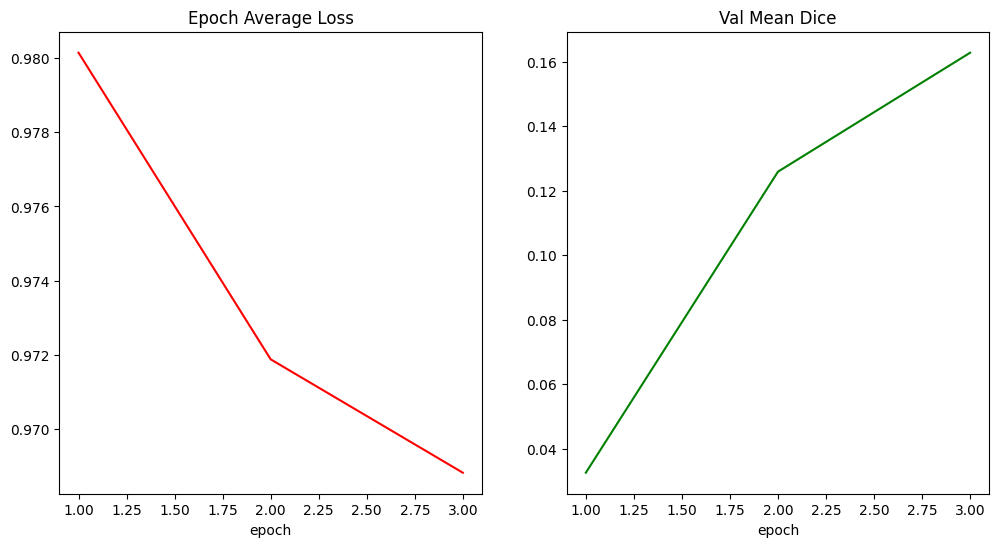

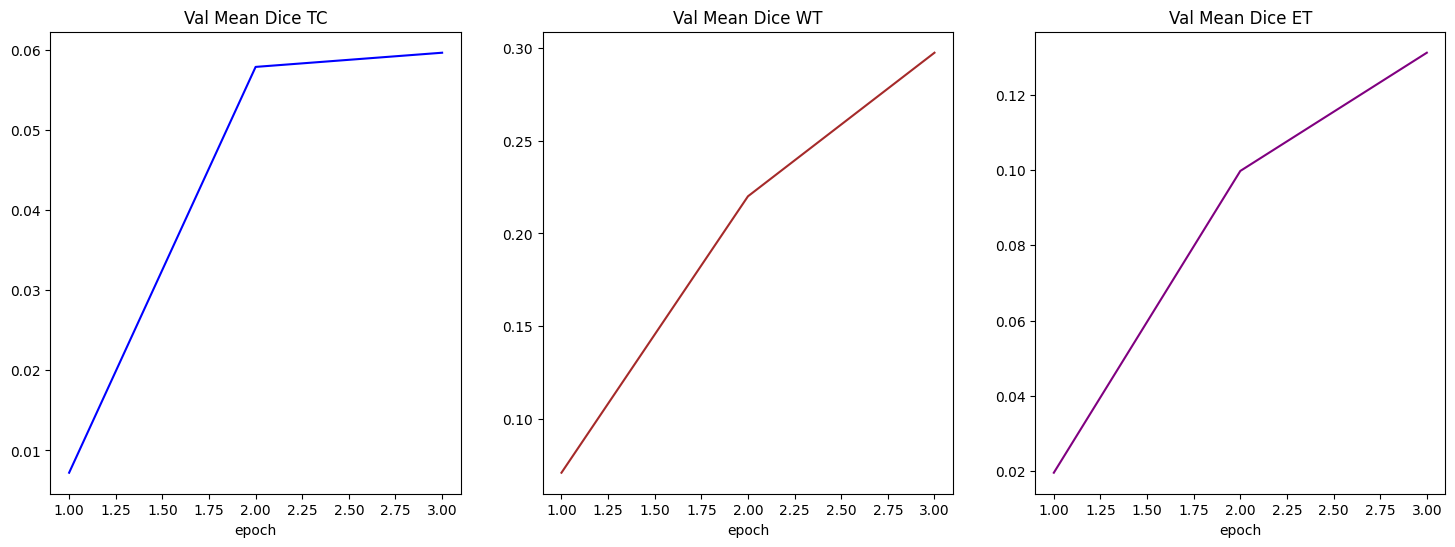

In [50]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y, color="red")
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y, color="green")
plt.show()

plt.figure("train", (18, 6))
plt.subplot(1, 3, 1)
plt.title("Val Mean Dice TC")
x = [val_interval * (i + 1) for i in range(len(metric_values_tc))]
y = metric_values_tc
plt.xlabel("epoch")
plt.plot(x, y, color="blue")
plt.subplot(1, 3, 2)
plt.title("Val Mean Dice WT")
x = [val_interval * (i + 1) for i in range(len(metric_values_wt))]
y = metric_values_wt
plt.xlabel("epoch")
plt.plot(x, y, color="brown")
plt.subplot(1, 3, 3)
plt.title("Val Mean Dice ET")
x = [val_interval * (i + 1) for i in range(len(metric_values_et))]
y = metric_values_et
plt.xlabel("epoch")
plt.plot(x, y, color="purple")
plt.show()

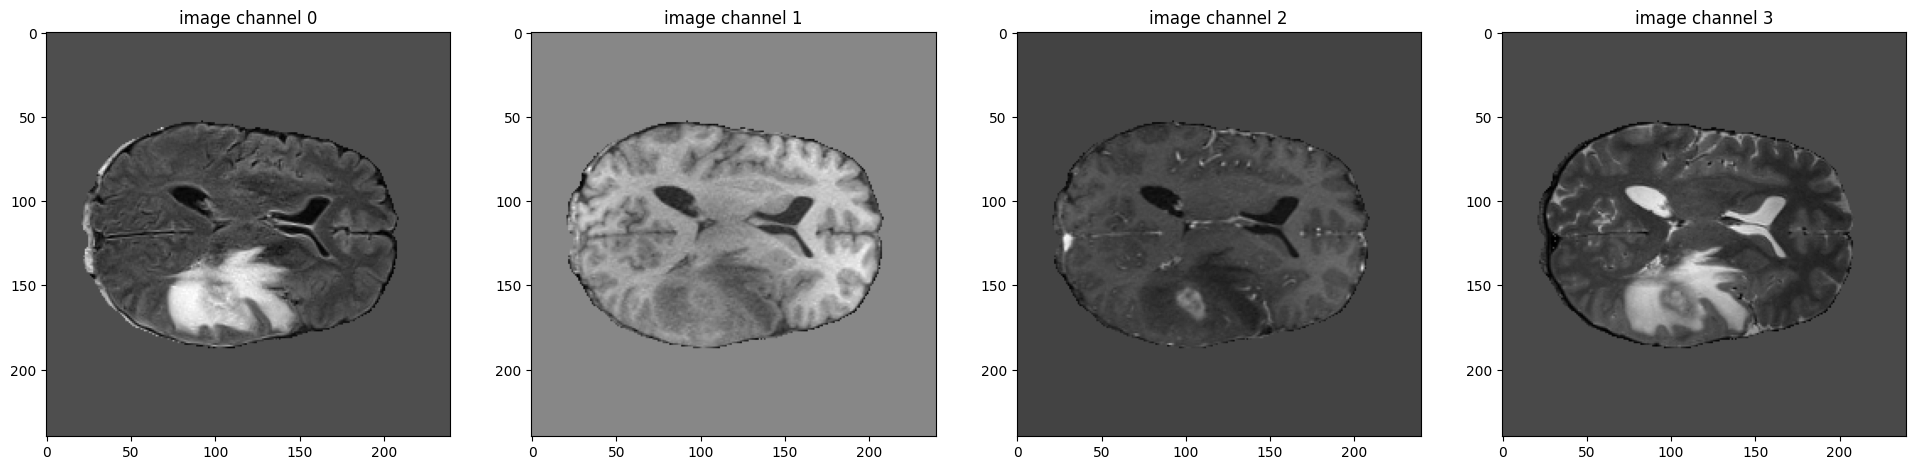

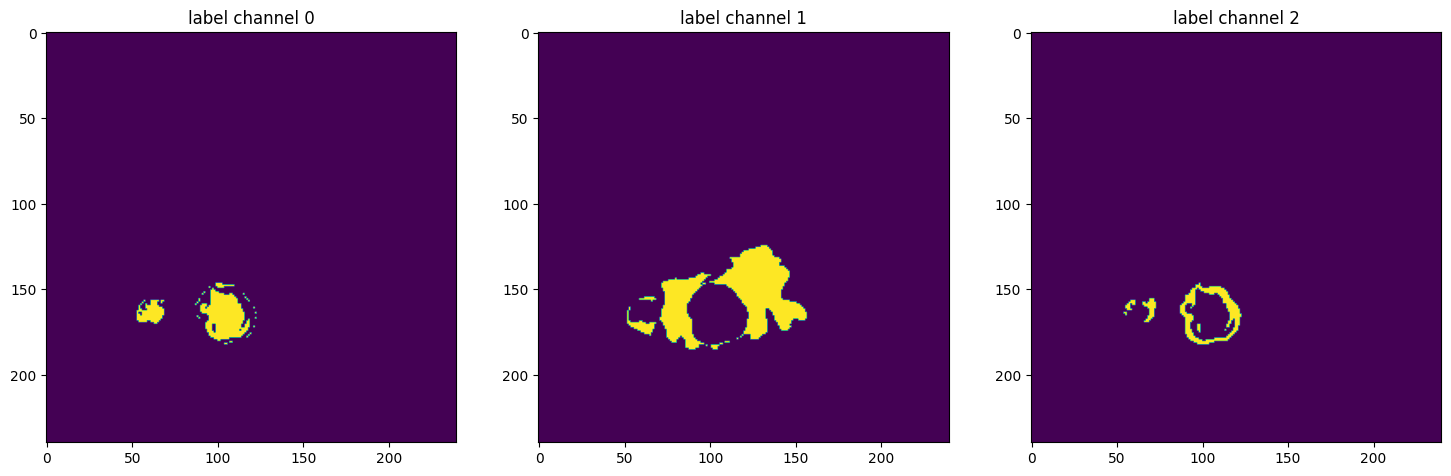

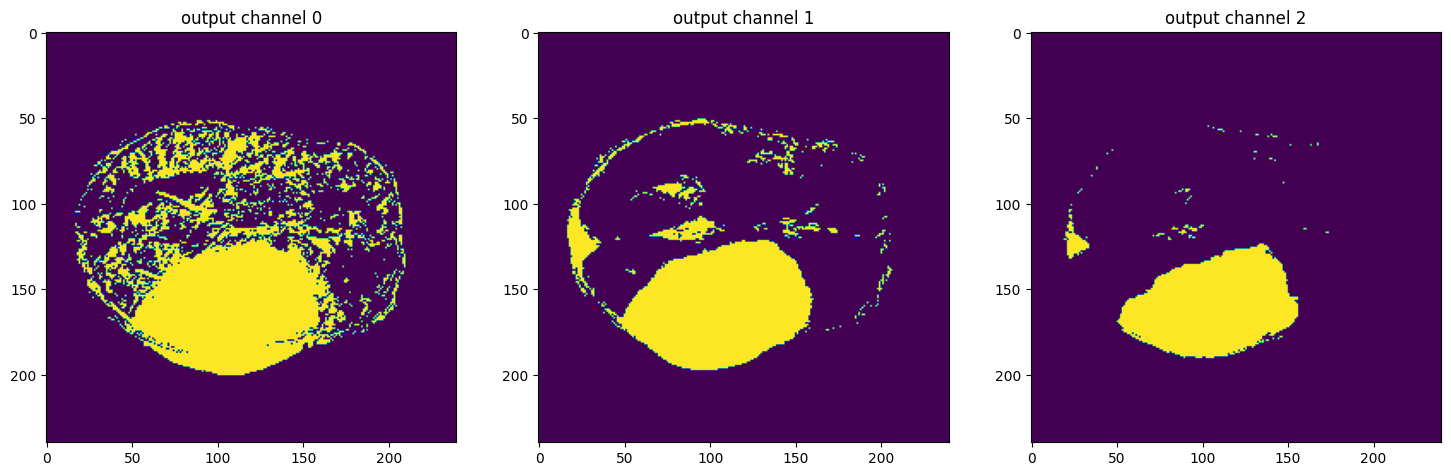

In [51]:
model.load_state_dict(torch.load(os.path.join(config.MODEL_PATH, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    # select one image to evaluate and visualize the model output
    val_input = val_ds[0]["image"].unsqueeze(0).to(device)
    roi_size = (128, 128, 64)
    sw_batch_size = 4
    val_output = inference(val_input)
    val_output = post_trans(val_output[0])
    plt.figure("image", (24, 6))
    for i in range(4):
        plt.subplot(1, 4, i + 1)
        plt.title(f"image channel {i}")
        plt.imshow(val_ds[0]["image"][i, :, :, 70].detach().cpu(), cmap="gray")
    plt.show()
    # visualize the 3 channels label corresponding to this image
    plt.figure("label", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"label channel {i}")
        plt.imshow(val_ds[0]["label"][i, :, :, 60].detach().cpu())
    plt.show()
    # visualize the 3 channels model output corresponding to this image
    plt.figure("output", (18, 6))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.title(f"output channel {i}")
        plt.imshow(val_output[i, :, :, 60].detach().cpu())
    plt.show()

# Evaluation on original image spacings

In [54]:
val_org_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image"]),
        ConvertToMultiChannelBasedOnBratsClassesd(keys="label"),
        Orientationd(keys=["image"], axcodes="RAS"),
        Spacingd(keys=["image"], pixdim=(1.0, 1.0, 1.0), mode="bilinear"),
        NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
    ]
)

# Create iterable Dataset and its Dataloader for Data validation
val_org_ds = Dataset(data=val_files,transform=val_org_transforms, )
val_org_loader = DataLoader(val_org_ds, batch_size=1, shuffle=False, num_workers=2)

post_transforms = Compose(
    [
        Invertd(
            keys="pred",
            transform=val_org_transforms,
            orig_keys="image",
            meta_keys="pred_meta_dict",
            orig_meta_keys="image_meta_dict",
            meta_key_postfix="meta_dict",
            nearest_interp=False,
            to_tensor=True,
            device="cpu",
        ),
        Activationsd(keys="pred", sigmoid=True),
        AsDiscreted(keys="pred", threshold=0.5),
    ]
)

# Load best model and make teh inference

In [ ]:
model.load_state_dict(torch.load(os.path.join(config.MODEL_PATH, "best_metric_model.pth")))
model.eval()

with torch.no_grad():
    for val_data in val_org_loader:
        val_inputs = val_data["image"].to(device)
        val_data["pred"] = inference(val_inputs)
        val_data = [post_transforms(i) for i in decollate_batch(val_data)]
        val_outputs, val_labels = from_engine(["pred", "label"])(val_data)
        dice_metric(y_pred=val_outputs, y=val_labels)
        dice_metric_batch(y_pred=val_outputs, y=val_labels)

    metric_org = dice_metric.aggregate().item()
    metric_batch_org = dice_metric_batch.aggregate()

    dice_metric.reset()
    dice_metric_batch.reset()

metric_tc, metric_wt, metric_et = metric_batch_org[0].item(), metric_batch_org[1].item(), metric_batch_org[2].item()

print("Metric on original image spacing: ", metric_org)
print(f"metric_tc: {metric_tc:.4f}")
print(f"metric_wt: {metric_wt:.4f}")
print(f"metric_et: {metric_et:.4f}")